<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap08_mnist_digit_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章：Autoencoderを作ってみよう
- 手書きの数字を1~9に分類するモデルを作成します

- 本Notebookのゴール感
  - コードを動かしながら画像解析に対する理解を深める

## GPUが使用可能であることを確認（第7章と同じ）
- 手動で設定する場合には「ランタイム」メニュー→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPU（T4 GPU、など）に設定→「保存」ボタンを押下

In [ ]:
!nvidia-smi  # ←GPUが使用可能であることを確認

Tue Jul 23 15:12:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ライブラリのインポート（第7章と同じ）

In [1]:
import tensorflow as tf

# Kerasのインポート
import keras
from keras import layers
from keras import initializers

# ネットワーク（モデル）を構築するための「部品」をインポートします
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのライブラリをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
# 結果の再現性を担保するために乱数シードを固定
keras.utils.set_random_seed(821)
tf.config.experimental.enable_op_determinism()

## 学習に使うデータの準備（第7章と同じ）

11490434/11490434 [==============================] - 0s 0us/step
学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


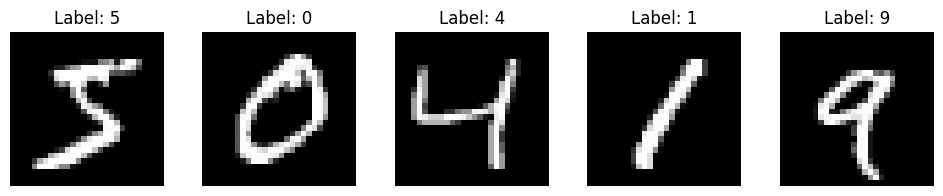

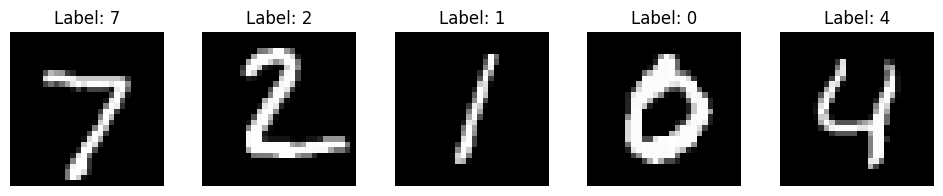

In [2]:
# @title ## データの準備（第7章と同じ）
# MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# データの正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから5個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=5)
# 検証用データから5個のサンプルを表示
plot_sample_images(x_test, y_test, num_samples=5)

In [3]:
# @title ## 学習用/検証用データに含まれる各ラベルの枚数を確認（第7章と同じ）
# 各ラベルの数を計算する関数
def count_labels(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

# 学習用データと検証用データのラベル数を計算
train_label_counts = count_labels(y_train)
test_label_counts = count_labels(y_test)

# データフレームにまとめる
df = pd.DataFrame({
    'ラベル': list(train_label_counts.keys()),
    '学習用データの数': list(train_label_counts.values()),
    '検証用データの数': [test_label_counts.get(label, 0) for label in train_label_counts.keys()]
})

# データフレームを表示
df

,ラベル,学習用データの数,検証用データの数
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


## Autoencoderを定義してみよう
- 第7章の"model02"の構造を参考にしたAutoencoderを作成します

In [4]:
# Decoderを構築するための「部品」をインポートします
from tensorflow.keras.layers import Reshape

# エンコーディングの次元数を設定
encoding_dim = 2

# モデルの定義
autoencoder01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(128, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),
    Reshape((28, 28))
], name='autoencoder01')

# モデルの構造を表示
autoencoder01.summary()

Model: "autoencoder01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 202258 (790.07 KB)
Trainable params: 20

### モデルを可視化してみよう

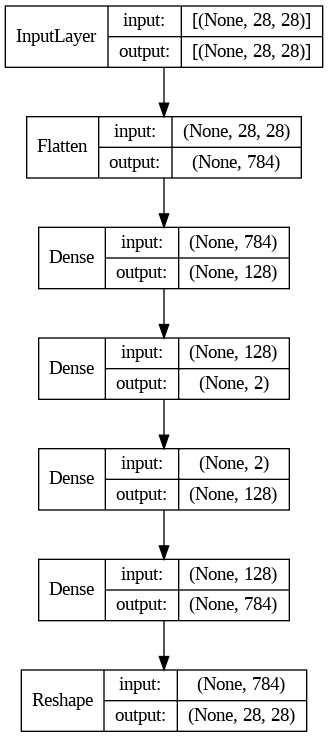

In [ ]:
# モデルを可視化して画像を出力
plot_model(autoencoder01, to_file='autoencoder01.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='autoencoder01.png'))

### モデルのコンパイルと学習

In [ ]:
# モデルのコンパイル
autoencoder01.compile(loss='mse',optimizer='adam')

# モデルを１エポックだけ学習
history = autoencoder01.fit(x_train, x_train,
                            epochs=1, # ←１エポックだけ学習させています
                            validation_data=(x_test, x_test))

1875/1875 [==============================] - 19s 6ms/step - loss: 0.0622 - val_loss: 0.0519


### 学習済みモデルを読み込み

In [5]:
from tensorflow.keras.models import load_model
# 指定されたURLから学習済みモデルをダウンロードして保存
!wget -O chap08_autoencoder01-01.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder01-01.h5

# ダウンロードしたファイルを読み込み、autoencoder01に代入
autoencoder01 = load_model('chap08_autoencoder01-01.h5')

--2024-07-24 08:42:03--  https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder01-01.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2470584 (2.4M) [application/octet-stream]
Saving to: ‘chap08_autoencoder01-01.h5’

chap08_autoencoder0 100%[===================>]   2.36M  --.-KB/s    in 0.07s   

2024-07-24 08:42:04 (31.7 MB/s) - ‘chap08_autoencoder01-01.h5’ saved [2470584/2470584]



313/313 [==============================] - 6s 14ms/step


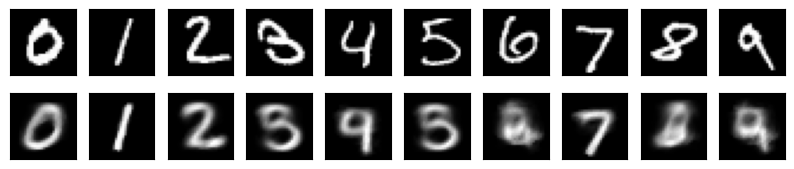

In [6]:
# @title ## Autoencoderの入出力を確認しよう
# @markdown - このコードセルを実行すると、予め指定した０～９の画像が再構築されて出力されます

# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder01.predict(x_test)

# ０～９までの数字のインデックス
digit_index_list = [3,2,1,18,4,15,11,0,61,7]

# 描画する画像サイズの指定
plt.figure(figsize=(10, 2))

# ０～９までの数字の入出力画像を表示
for i,digit_index in enumerate(digit_index_list):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

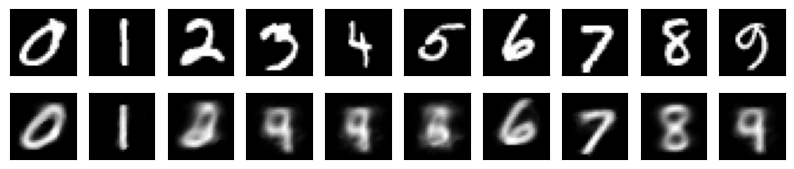

In [ ]:
# @title ### 参考：０～９の数字をランダムに選んでデコード具合を確認してみよう
# @markdown - このコードセルを実行するたびに、ランダムに０～９の数字が選択され、デコード具合を確認することができます
import random, time

# 現在時刻からランダムシードを決定する
random_seed = int(time.time())
random.seed(random_seed)

# ０～９までの数字のインデックス
digit_index_list_rnd = []
for lbl in range(10):
    lbl_indices = np.where(y_test == lbl)[0]
    digit_index_list_rnd.append(random.choice(lbl_indices))
#
plt.figure(figsize=(10, 2))
for i,digit_index in enumerate(digit_index_list_rnd):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list_rnd), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, len(digit_index_list_rnd), i+1+len(digit_index_list_rnd))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# @title - 画像を保存してZIP化
# Directory to save the images
import os
output_dir_test = './auto01'
output_dir_decoded = './auto01'
os.makedirs(output_dir_test, exist_ok=True)
os.makedirs(output_dir_decoded, exist_ok=True)

# Loop through the digit index list and save each image separately
for i, digit_index in enumerate(digit_index_list):
    # Save test image
    plt.figure(figsize=(10, 10))
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    plt.savefig(os.path.join(output_dir_test, f'test_image_{i}.png'))
    plt.close()

    # Save decoded image
    plt.figure(figsize=(10, 10))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    plt.savefig(os.path.join(output_dir_decoded, f'decoded_image_{i}.png'))
    plt.close()

# List the saved files for confirmation
saved_files_test = os.listdir(output_dir_test)
saved_files_decoded = os.listdir(output_dir_decoded)
saved_files_test, saved_files_decoded
!zip -r ./auto01.zip ./auto01

updating: auto01/ (stored 0%)
updating: auto01/test_image_8.png (deflated 79%)
updating: auto01/decoded_image_9.png (deflated 72%)
updating: auto01/test_image_1.png (deflated 85%)
updating: auto01/decoded_image_8.png (deflated 71%)
updating: auto01/test_image_2.png (deflated 80%)
updating: auto01/test_image_6.png (deflated 78%)
updating: auto01/test_image_0.png (deflated 79%)
updating: auto01/decoded_image_7.png (deflated 75%)
updating: auto01/test_image_4.png (deflated 81%)
updating: auto01/test_image_9.png (deflated 79%)
updating: auto01/decoded_image_6.png (deflated 71%)
updating: auto01/test_image_7.png (deflated 82%)
updating: auto01/test_image_5.png (deflated 81%)
updating: auto01/decoded_image_2.png (deflated 72%)
updating: auto01/decoded_image_5.png (deflated 72%)
updating: auto01/decoded_image_1.png (deflated 82%)
updating: auto01/decoded_image_4.png (deflated 74%)
updating: auto01/decoded_image_0.png (deflated 72%)
updating: auto01/decoded_image_3.png (deflated 71%)
updating:

## Encoderの出力結果を確認しよう

313/313 [==============================] - 1s 4ms/step


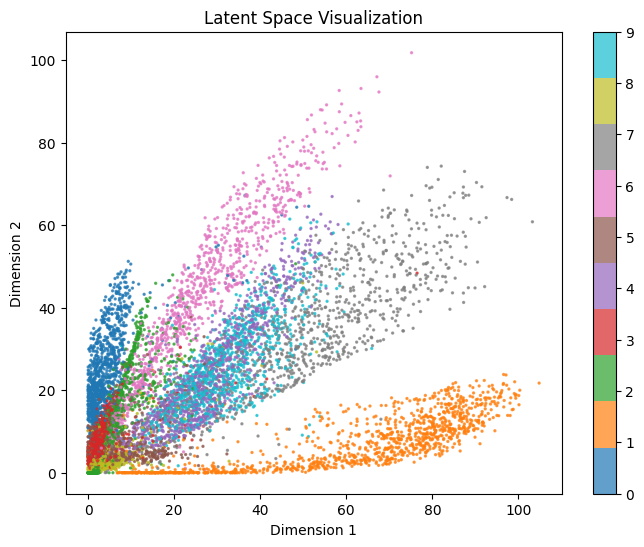

In [9]:
# エンコーダ部分の定義
encoder = keras.models.Model(inputs=autoencoder01.input,
                             outputs=autoencoder01.layers[2].output)

# テストデータの潜在表現を取得
encoded_imgs = encoder.predict(x_test)

# 潜在表現の可視化
plt.figure(figsize=(8, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, s=2, alpha=0.7,cmap='tab10')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# 以下はAppendix

1/1 [==============================] - 0s 180ms/step


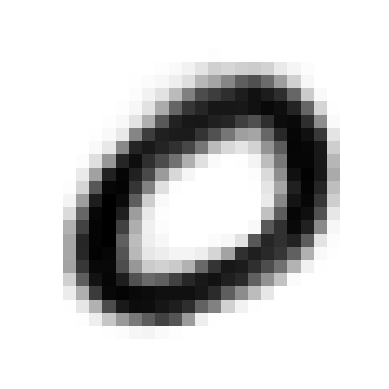

In [ ]:
# @title ## 存在しない画像を書いてみよう
# 立体的に可視化してみよう
Dimension1 = 5 #@param {type:"slider", min:0, max:120, step:1}
Dimension2 = 38 #@param {type:"slider", min:0, max:120, step:1}

from keras.layers import Input
# デコーダ部分の定義
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder01.layers[3]
decoder_layer2 = autoencoder01.layers[4]

decoder = Sequential([
    decoder_layer1,
    decoder_layer2
], name='decoder')

# 2次元ベクトルから画像を生成
def generate_image(latent_vector):
    generated_image = decoder.predict(np.array([latent_vector]))
    return generated_image.reshape(28, 28)

# サンプルの2次元ベクトル
sample_latent_vector = [Dimension1, Dimension2]

# 画像生成
generated_image = generate_image(sample_latent_vector)

# 生成された画像を表示
plt.imshow(generated_image, cmap='binary')
# plt.colorbar()
# plt.title('Generated Image from Latent Representation')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 140ms/step


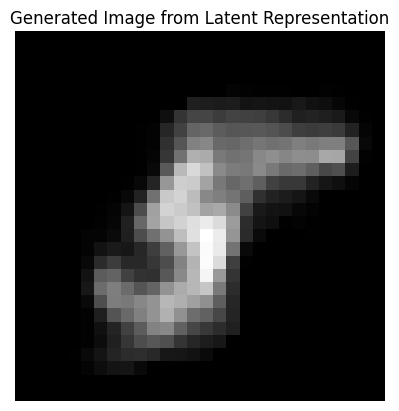

In [ ]:
# @title ## 存在しない画像を書いてみよう
# 立体的に可視化してみよう
Dimension1 = 20 #@param {type:"slider", min:0, max:120, step:1}
Dimension2 = 5 #@param {type:"slider", min:0, max:120, step:1}

from keras.layers import Input
# デコーダ部分の定義
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder01.layers[3]
decoder_layer2 = autoencoder01.layers[4]

decoder = Sequential([
    decoder_layer1,
    decoder_layer2
], name='decoder')

# 2次元ベクトルから画像を生成
def generate_image(latent_vector):
    generated_image = decoder.predict(np.array([latent_vector]))
    return generated_image.reshape(28, 28)

# サンプルの2次元ベクトル
sample_latent_vector = [Dimension1, Dimension2]

# 画像生成
generated_image = generate_image(sample_latent_vector)

# 生成された画像を表示
plt.imshow(generated_image, cmap='gray')
# plt.colorbar()
plt.title('Generated Image from Latent Representation')
plt.axis('off')
plt.show()

In [ ]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# @title ## 参考：モデルを自分で学習してみよう
# @markdown - このコードセルを実行すると、10エポック学習されます（少し時間がかかります）

# 学習曲線を描画する関数
def plot_learning_curve(history):
    # 学習用データと検証用データの損失を取得
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # エポック数の範囲を設定
    epochs = range(1, len(loss) + 1)

    # 損失をプロット
    plt.figure(figsize=(6, 4))  # グラフのサイズを設定
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # 学習用データの損失をプロット
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 検証用データ損失をプロット
    plt.title('Training and validation loss')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Loss')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    plt.show()  # グラフを表示

# モデル構築
encoding_dim = 2
autoencoder01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(128, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),  # 出力ユニットを 28 * 28 に設定
    Reshape((28, 28))  # 出力を 28x28x1 の形に戻す
], name='autoencoder01')

# モデルのコンパイル
autoencoder01.compile(loss='mse',optimizer='adam')

# モデルの学習
history = autoencoder01.fit(x_train, x_train,
                            epochs=10,
                            validation_data=(x_test, x_test))
plot_learning_curve(history)

# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder01.predict(x_test)

# 再現性を確保するため、モデルの重みを保存します
autoencoder01.save('original_autoencoder01.h5')

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0582 - accuracy: 0.1133 - val_loss: 0.0512 - val_accuracy: 0.1362
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0497 - accuracy: 0.1409 - val_loss: 0.0481 - val_accuracy: 0.1449
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0473 - accuracy: 0.1488 - val_loss: 0.0466 - val_accuracy: 0.1506
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0460 - accuracy: 0.1531 - val_loss: 0.0455 - val_accuracy: 0.1556
Epoch 5/10
1592/1875 [========================>.....] - ETA: 0s - loss: 0.0450 - accuracy: 0.1570

KeyboardInterrupt: 

### Flattenにしてみる

In [ ]:
# モデル構築
encoding_dim = 2
autoencoder01 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(64, activation='relu'),
    Dense(256, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),  # 出力ユニットを 28 * 28 に設定
    Reshape((28, 28, 1))  # 出力を 28x28x1 の形に戻す
], name='autoencoder01')

autoencoder01.compile(optimizer='adam', loss='mse')
autoencoder01.summary()

# 学習
autoencoder01.fit(x_train, x_train,
                epochs=10,
                validation_data=(x_test, x_test))

# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder01.predict(x_test)

Model: "autoencoder01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 784)             

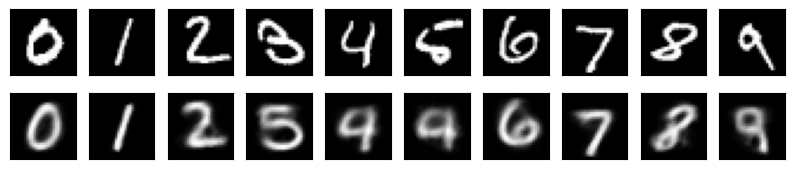

In [ ]:
# ０～９までの数字のインデックス
digit_index_list = [3,2,1,18,4,8,11,0,61,7]
plt.figure(figsize=(10, 2))
for i,digit_index in enumerate(digit_index_list):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 1s 2ms/step


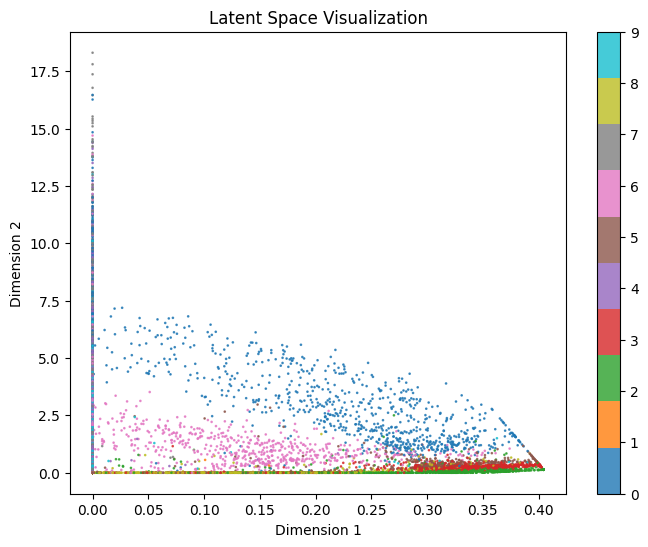

In [ ]:
# エンコーダ部分の定義
encoder = Model(inputs=autoencoder01.input,
                outputs=autoencoder01.layers[3].output)

# テストデータの潜在表現を取得
encoded_imgs = encoder.predict(x_test)

# 潜在表現の可視化
plt.figure(figsize=(8, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, s=0.8, alpha=0.8,cmap='tab10')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

### 潜在表現の次元を３にして、3Dで可視化してみよう

In [ ]:
# モデル構築
encoding_dim = 3
autoencoder = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(64, activation='relu'),
    Dense(256, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),  # 出力ユニットを 28 * 28 に設定
    Reshape((28, 28, 1))  # 出力を 28x28x1 の形に戻す
], name='autoencoder')

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# 学習
autoencoder.fit(x_train, x_train,
                epochs=50,
                validation_data=(x_test, x_test))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               200960    
                                                                 
 dense_31 (Dense)            (None, 64)                16448     
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
 dense_33 (Dense)            (None, 64)                256       
                                                                 
 dense_34 (Dense)            (None, 256)               16640     
                                                                 
 dense_35 (Dense)            (None, 784)               

KeyboardInterrupt: 

In [ ]:
# エンコーダ部分の定義
encoder = Model(inputs=autoencoder.input,
                outputs=autoencoder.layers[3].output)

# テストデータの潜在表現を取得
encoded_imgs = encoder.predict(x_test)

import plotly.express as px
# 潜在表現の可視化
fig = px.scatter_3d(
    x=encoded_imgs[:, 0],
    y=encoded_imgs[:, 1],
    z=encoded_imgs[:, 2],
    color=y_test,
    labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'z': 'Dimension 3'},
    title='3D Latent Space Visualization'
)
# マーカーサイズを設定
fig.update_traces(marker=dict(size=1.))

fig.show()

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# モデル構築
encoding_dim = 2
autoencoder = Sequential([
    # エンコーダ部分
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(6, kernel_size=(2, 2), input_shape=(28, 28, 1), activation='ReLU'), #← 第一の畳み込み層
    MaxPooling2D(pool_size=(2, 2)), #← 第一の最大値プーリング層
    Conv2D(16, kernel_size=(2, 2), activation='ReLU'),#← 第二の畳み込み層
    MaxPooling2D(pool_size=(2, 2)),#← 第二の最大値プーリング層
    # デコーダ部分
    Conv2D(16, kernel_size=(2, 2), activation='relu'),  # 第一の逆畳み込み層
    UpSampling2D(size=(2, 2)),  # 第一のアップサンプリング層
    Conv2D(6, kernel_size=(2, 2), activation='relu'),  # 第二の逆畳み込み層
    UpSampling2D(size=(2, 2)),  # 第二のアップサンプリング層
    Conv2D(1, kernel_size=(2, 2), activation='sigmoid', padding='same')  # 出力層
], name='autoencoder')

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# 学習
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 2))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 27, 27, 6)         30        
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 12, 16)        400       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 5, 5, 16)          1040      
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 10, 10, 16)        

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5830, in binary_crossentropy
        bce = target * tf.math.log(output + epsilon())

    ValueError: Dimensions must be equal, but are 28 and 18 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:1, binary_crossentropy/Log)' with input shapes: [?,28,28], [?,18,18].


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

# データのロードと前処理
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # (サンプル数, 28, 28, 1)
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))    # (サンプル数, 28, 28, 1)

# モデル構築
input_img = Input(shape=(28, 28, 1))

# モデル構築
encoding_dim = 32

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(encoding_dim, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# モデル定義
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

# 学習
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# 学習モデルでテスト画像を変換
decoded_imgs = autoencoder.predict(x_test)

# 変換結果の表示
n = 10
plt.figure(figsize=(10, 2))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          18464 

UnimplementedError: Graph execution error:

Detected at node gradient_tape/model/up_sampling2d_1/resize/ResizeNearestNeighborGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-7-2fda4dfcc4fc>", line 40, in <cell line: 40>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

A deterministic GPU implementation of ResizeNearestNeighborGrad is not currently available.
	 [[{{node gradient_tape/model/up_sampling2d_1/resize/ResizeNearestNeighborGrad}}]] [Op:__inference_train_function_1552]

## 関数の定義

In [ ]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# 学習曲線を描画する関数
def plot_learning_curve(history):
    # 学習用データと検証用データの正解率を取得
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # 学習用データと検証用データの損失を取得
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # エポック数の範囲を設定
    epochs = range(1, len(acc) + 1)

    # 正解率をプロット
    plt.figure(figsize=(12, 4))  # グラフのサイズを設定
    plt.subplot(1, 2, 1)  # 2つのサブプロットのうち1つ目
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')  # 学習用データの正解率をプロット
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')  # 検証用データの正解率をプロット
    plt.title('Training and validation accuracy')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Accuracy')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    # 損失をプロット
    plt.subplot(1, 2, 2)  # 2つのサブプロットのうち2つ目
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # 学習用データの損失をプロット
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 検証用データ損失をプロット
    plt.title('Training and validation loss')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Loss')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    plt.show()  # グラフを表示

## もっとも単純なモデルを作ってみよう

Model: "model01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


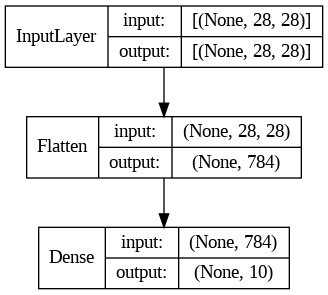

In [ ]:
# モデルの定義
model01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(10, activation='softmax')
], name='model01')

# モデルのサマリーを表示
model01.summary()

# モデルを可視化して画像を出力
plot_model(model01, to_file='model01.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model01.png'))

### モデルのコンパイルと学習

In [ ]:
# コンパイルと学習を行う関数を定義
def compile_and_learn(model):
    # モデルをコンパイルする
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # モデルの学習
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)
    # 学習曲線の描画
    plot_learning_curve(history)
    return model

# コンパイルと学習を実行
compile_and_learn(model01)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.4671 - accuracy: 0.8783 - val_loss: 0.3058 - val_accuracy: 0.9156
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3033 - accuracy: 0.9153 - val_loss: 0.2830 - val_accuracy: 0.9219
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2830 - accuracy: 0.9213 - val_loss: 0.2740 - val_accuracy: 0.9236
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2728 - accuracy: 0.9238 - val_loss: 0.2698 - val_accuracy: 0.9259
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2669 - accuracy: 0.9257 - val_loss: 0.2659 - val_accuracy: 0.9261


### 混同行列（confusion matrix）を作成しよう

In [ ]:
# 混同行列を描画する関数
def plot_confusion_matrix(model):
    # 検証用データに対する予測
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # 混同行列の作成
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    # 混同行列の表示
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# コンパイルと学習を実行
plot_confusion_matrix(model01)

In [ ]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "2" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 予測を誤ってしまった画像を表示する関数
def check_incorrect_predictions(model,label,numd):
    # 検証用データに対する予測
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # 実際のラベルが`label`で与えられたものと等しく、かつ予測が間違っている画像のインデックスを取得
    incorrect_indices = np.where((y_test == label) & (y_pred_classes != label))[0]

    # 画像を表示する
    num_images_to_show = min(numd, len(incorrect_indices))  # 表示する画像の数を設定
    plt.figure(figsize=(numd, 2))
    for i, index in enumerate(incorrect_indices[:num_images_to_show]):
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {y_pred_classes[index]}")
        plt.axis('off')
    plt.show()

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model01,int(正解ラベル),表示数)

## 中間層を追加したモデルを作ってみよう

In [ ]:
# モデルの定義
model02 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model02')

# モデルのサマリーを表示
model02.summary()

# モデルを可視化して画像を出力
plot_model(model02, to_file='model02.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model02.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2633 - accuracy: 0.9243 - val_loss: 0.1483 - val_accuracy: 0.9526
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1153 - accuracy: 0.9652 - val_loss: 0.1022 - val_accuracy: 0.9699
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0798 - accuracy: 0.9763 - val_loss: 0.1012 - val_accuracy: 0.9672
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0752 - val_accuracy: 0.9762
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0751 - val_accuracy: 0.9762


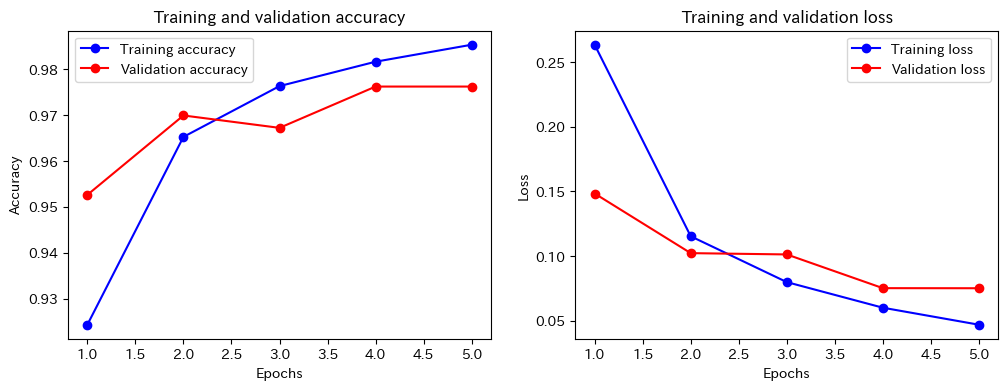

In [ ]:
# コンパイルと学習を実行
compile_and_learn(model02)

313/313 [==============================] - 1s 1ms/step


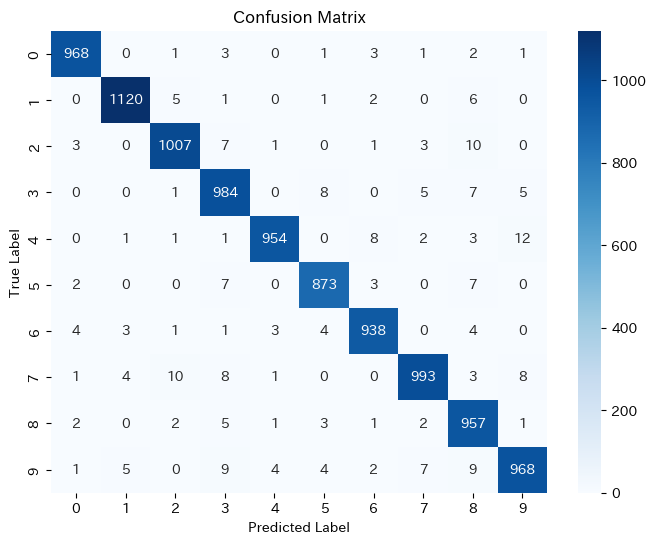

In [ ]:
# @title ## 参考：混同行列（confusion matrix）を作成しよう
plot_confusion_matrix(model02)

313/313 [==============================] - 0s 1ms/step


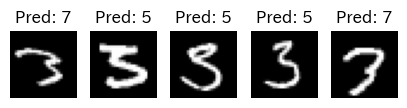

In [ ]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "3" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model02,int(正解ラベル),表示数)

## 高度なモデルを作ってみよう

Model: "model03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 6)         30        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        400       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               7385

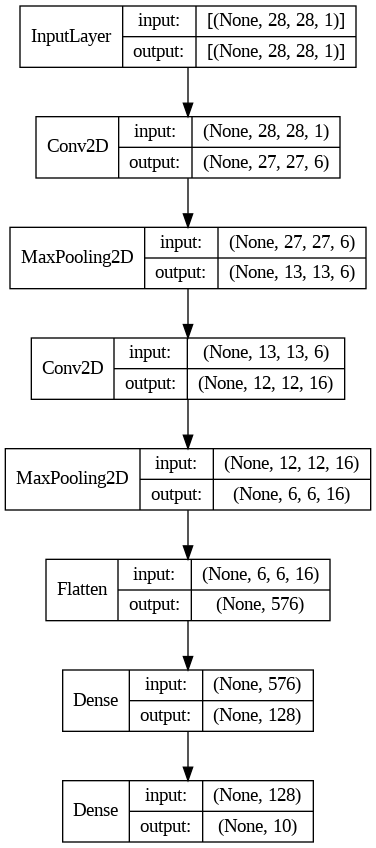

In [ ]:
# モデルの定義
model03 = Sequential([
    Conv2D(6, kernel_size=(2, 2), input_shape=(28, 28, 1), activation='ReLU'), #← 第一の畳み込み層
    MaxPooling2D(pool_size=(2, 2)), #← 第一の最大値プーリング層
    Conv2D(16, kernel_size=(2, 2), activation='ReLU'),#← 第二の畳み込み層
    MaxPooling2D(pool_size=(2, 2)),#← 第二の最大値プーリング層
    Flatten(),#← 全結合層
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model03')

# モデルのサマリーを表示
model03.summary()

# モデルを可視化して画像を出力
plot_model(model03, to_file='model03.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model03.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2132 - accuracy: 0.9372 - val_loss: 0.0781 - val_accuracy: 0.9758
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0728 - accuracy: 0.9779 - val_loss: 0.0602 - val_accuracy: 0.9799
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.0506 - val_accuracy: 0.9835
Epoch 4/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.0455 - val_accuracy: 0.9853
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0304 - accuracy: 0.9904 - val_loss: 0.0390 - val_accuracy: 0.9873


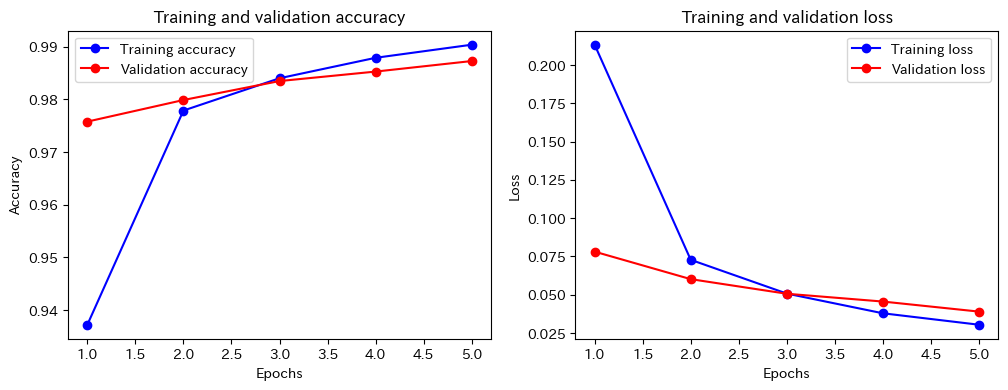

In [ ]:
# コンパイルと学習を実行
compile_and_learn(model03)

### 参考：混同行列（confusion matrix）を作成しよう

313/313 [==============================] - 1s 2ms/step


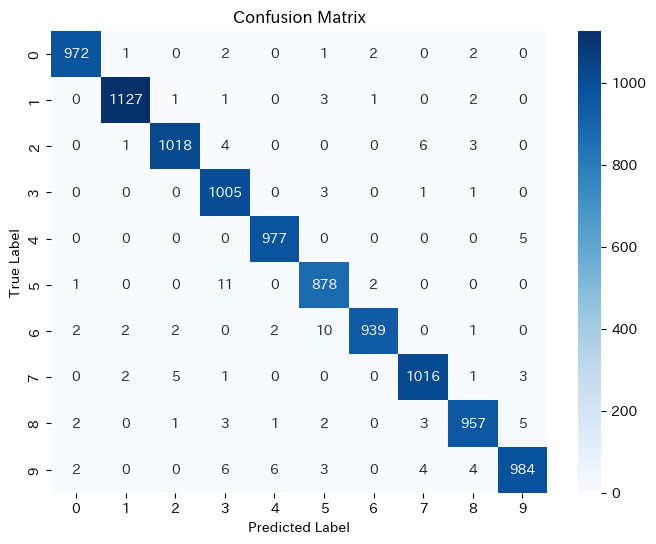

In [ ]:
plot_confusion_matrix(model03)

313/313 [==============================] - 1s 2ms/step


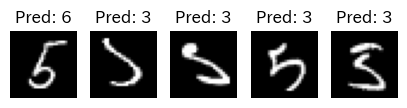

In [ ]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "5" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model03,int(正解ラベル),表示数)

In [ ]:
# @title ## 参考：GUIで手書き文字を認識しよう
!pip install gradio==4.29.0
import gradio as gr
import numpy as np

model_name = "model03"  # @param ["model01", "model02", "model03"]
if model_name == "model01":
    md = model01
elif model_name == "model02":
    md = model02
elif model_name == "model03":
    md = model03

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0  # Normalize the image to range [0, 1]
    return normalized_image

# Define the prediction function
def classify(sketch):
    image = sketch["composite"]
    grayscale_image = np.mean(image, axis=2)  # Average across RGB channels

    # Resize and normalize the image
    resized_image = reshape_to_28x28(grayscale_image)

    # Convert the image to the correct shape for the model
    reshaped_image = resized_image.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

    # Make predictions and convert the result to a list
    pred = md.predict(reshaped_image).tolist()[0]

    # Get the top 3 predictions
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # Store confidences in a dictionary
    confidences = {str(i): v for i, v in zip(indices, values)}

    return confidences

# Gradioインターフェースを作成
gr.Interface(
    fn=classify,
    inputs="sketchpad",
    outputs="label",
).launch(debug=True)

In [ ]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# @title ## 参考：評価用画像でモデルごとの精度を確認しよう
from PIL import Image as PILImage
import numpy as np

model_name = "model03"  # @param ["model01", "model02", "model03"]
if model_name == "model01":
    md = model01
elif model_name == "model02":
    md = model02
elif model_name == "model03":
    md = model03

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0
    return normalized_image

# 推論用の関数
def predict_image(model, image_path, dsp=False):
    # 画像を読み込む
    image = PILImage.open(image_path)
    grayscale_image = np.mean(image, axis=2)

     # 画像をリサイズし、正規化する
    resized_image = reshape_to_28x28(grayscale_image)

    # モデル用に画像を正しい形状に変換する
    reshaped_image = resized_image.reshape(1, 28, 28, 1)

    # 予測を行い、結果をリストに変換する
    pred = md.predict(reshaped_image).tolist()[0]

    # 上位3つの予測を取得する
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # 結果を表示
    if dsp:
        plt.imshow(resized_image, cmap='gray')
        plt.axis('off')
        plt.show()

    # トップ5の予測結果を出力
    results = []
    for v,i in zip(values, indices):
        # print(f"Label {i}: Probability {v:.4f}")
        results.append({
            'Label': i,
            'Probability': v
        })
    return pd.DataFrame(results)

# 評価用画像のダウンロード
!wget -O chap07_sample_digit_5.png https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap07_sample_digit_5.png

# PNG画像のパス
image_path = 'chap07_sample_digit_5.png'

print("◆◆ 検証用画像 ◆◆")
# 推論を実行
res_df = predict_image(md, image_path, dsp=True)
res_df

In [ ]:
# @title ## 参考：モデルの可視化を行うコード
# ネットワーク構造を可視化するためのライブラリをインストールします
!pip install visualkeras==0.1.0
import visualkeras

# 立体的に可視化してみよう
model_name = "model03" # @param ["model01", "model02", "model03"]
if model_name=="model01":
    md=model01
elif model_name=="model02":
    md=model02
elif model_name=="model03":
    md=model03
visualkeras.layered_view(md, legend=True, show_dimension=True)